# 시바견과 진돗개 구분하기 3

### Pretrained Inception-v3 을 이용해 볼 것이다.

https://sefiks.com/2017/12/10/transfer-learning-in-keras-using-inception-v3/m

그 전에 데이터를 다시 정제했기에, 기존 네트워크로 한 번 실행해볼 것이다. 

Stanford의 dog breed classification 처럼 class당 데이터의 갯수를 줄여보았다. 

어느 네트워크를 적용하나 데이터에 문제가 있다고 판단하여 2탄에서 pretrained를 적용하고 여기서 마무리 할 것이다. 

# 시바견과 비글

다른 견종을 넣었을 때는 성능이 더 높아질 것 같아서 넣어보았다. 실제 육안으로도 쉽게 구별 가능한 비글과 시바견을 분류 대상으로 정했다. 

# 필요한 모듈먼저 부르기

In [2]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np
import os
import tqdm
import random
from sklearn.datasets import load_files

# 다시 데이터 불러오기

In [170]:
X_dog = list()
# 네이버사진은 이상해서..
for fileName in os.listdir('./shiba'):
    if fileName.startswith('google'): #or fileName.startswith('aug'):
        X_dog.append(fileName)

In [171]:
len(X_dog)

183

In [172]:
for fileName in os.listdir('./비글'):
    X_dog.append(fileName)

In [173]:
len(X_dog)

378

시바견 : 183 / 진돗개 : 198

In [175]:
n_shiba = 183
n_jindo = 195

# Category 만들기

시바견이면 [1,0]

진돗개면 [0,1]

In [176]:
shiba_labels = list(list([1,0] for _ in range(n_shiba)))
jindo_labels = list(list([0,1] for _ in range(n_jindo)))

In [177]:
len(shiba_labels), len(jindo_labels)

(183, 195)

In [178]:
labels = shiba_labels + jindo_labels

In [179]:
len(labels),labels[:3]

(378, [[1, 0], [1, 0], [1, 0]])

# Image_resize

In [180]:
resize_dog = list()

for dog in X_dog[:n_shiba]:
    img = cv2.imread('./shiba/' + dog,cv2.IMREAD_GRAYSCALE)
    resize = cv2.resize(img,(224,224))
    resize = cv2.normalize(resize,resize,0,255,cv2.NORM_MINMAX)    
    resize_dog.append(resize)

In [181]:
len(resize_dog)

183

In [183]:
for i in X_dog[n_shiba:]:
    img = cv2.imread('./비글/'+i,cv2.IMREAD_GRAYSCALE)
    resize = cv2.resize(img,(224,224))
    resize = cv2.normalize(resize,resize,0,255,cv2.NORM_MINMAX)
    resize_dog.append(resize)

In [184]:
len(resize_dog)

378

[1, 0]


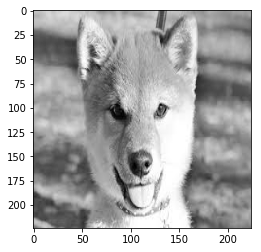

In [185]:
# 잘 됐는지 임의로 하나 출력해보자. 
plt.imshow(resize_dog[2],cmap=plt.cm.gray)
print(labels[1])
plt.show()

In [186]:
# data shuffle

np.random.seed(42)
tmp = [[x,y] for x, y in zip(resize_dog, labels)]
random.shuffle(tmp)
X_sample = [n[0] for n in tmp]
y_sample = [n[1] for n in tmp]

In [187]:
# Train / Test Split
# 80 : 20
train_size = np.ceil(0.8 * len(resize_dog)).astype(int) # 381 / 나머지 95개 test 할당

X_train = X_sample[:train_size]
y_train = y_sample[:train_size]

X_test = X_sample[train_size:]
y_test = y_sample[train_size:]



In [188]:
from keras_preprocessing.image import img_to_array

In [189]:

X_train = img_to_array(X_train)
y_train = np.array(y_train)

X_test = img_to_array(X_test)
y_test = np.array(y_test)

In [190]:
len(X_train), len(y_train), len(X_test), len(y_test)

(303, 303, 75, 75)

[0 1]


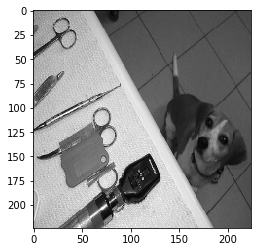

In [191]:
plt.imshow(X_test[1],cmap=plt.cm.gray)
print(y_test[1])
plt.show()

# Network 구축하기 

by Keras

In [192]:
IMG_SIZE = 224
# (None,224,224,1) 형태로 reshape
X_train = X_train.reshape(X_train.shape[0],IMG_SIZE,IMG_SIZE,1)
X_test = X_test.reshape(X_test.shape[0],IMG_SIZE,IMG_SIZE,1)

In [193]:
from keras import models
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense

In [197]:
IMG_SIZE = 224
def Network(name):
    
    name.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Dropout(0.7))
    name.add(Flatten())
    name.add(Dense(128, activation='relu'))
    name.add(Dropout(0.7))
    name.add(Dense(2, activation = 'softmax'))

In [198]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 5)

In [199]:
from keras import optimizers
model_early_sgd = models.Sequential()
Network(model_early_sgd)
model_early_sgd.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=0.01, momentum=0.9), 
              metrics=['accuracy'])

In [200]:
len(X_train), len(y_train)

(303, 303)

In [201]:
history_early = model_early_sgd.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1,validation_split=0.2,callbacks=[early_stopping])

Train on 242 samples, validate on 61 samples
Epoch 1/50
242/242 [==============================] - 26s 106ms/step - loss: 1.4942 - acc: 0.6446 - val_loss: 8.4554 - val_acc: 0.4754
Epoch 2/50
242/242 [==============================] - 20s 84ms/step - loss: 1.4335 - acc: 0.6364 - val_loss: 8.4554 - val_acc: 0.4754
Epoch 3/50
242/242 [==============================] - 23s 94ms/step - loss: 1.1821 - acc: 0.6860 - val_loss: 8.1755 - val_acc: 0.4754
Epoch 4/50
242/242 [==============================] - 19s 78ms/step - loss: 0.8455 - acc: 0.7231 - val_loss: 5.3165 - val_acc: 0.5246
Epoch 5/50
242/242 [==============================] - 20s 81ms/step - loss: 0.9165 - acc: 0.7686 - val_loss: 4.5909 - val_acc: 0.5902
Epoch 6/50
242/242 [==============================] - 23s 94ms/step - loss: 0.7333 - acc: 0.7769 - val_loss: 3.8933 - val_acc: 0.6066
Epoch 7/50
242/242 [==============================] - 24s 101ms/step - loss: 0.6899 - acc: 0.7851 - val_loss: 8.4554 - val_acc: 0.4754
Epoch 8/50
242/

In [203]:
loss, acc = model_early_sgd.evaluate(X_test,y_test,verbose=0)
print("Accuracy : %0.2f" % (acc*100))

Accuracy : 90.67


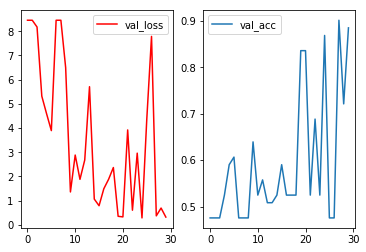

In [208]:
plt.subplot(1,2,1)
plt.plot(history_early.history['val_loss'],'r-',label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_early.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

# 90%의 정확도

확실히 육안으로도 쉽게 구별되는 만큼 Test Set을 잘 구분해냈다. 이로써 네트워크보다는 데이터에 문제가 조금 더 있을을 알고 다른 Optimizer들을 이용하고 Early stopping을 이용해서 학습해보았다. 

# Augmentation 후 성능평가

In [74]:
X_dog = list()
# 네이버사진은 이상해서..
for fileName in os.listdir('./shiba'):
    if fileName.startswith('google') or fileName.startswith('aug'):
        X_dog.append(fileName)

In [75]:
len(X_dog)

915

In [76]:
for fileName in os.listdir('./진돗개2'):
    X_dog.append(fileName)

In [77]:
len(X_dog)

1865

In [78]:
1865-915

950

시바견 : 183 / 진돗개 : 198

In [79]:
n_shiba = 915
n_jindo = 950

# Category 만들기

시바견이면 [1,0]

진돗개면 [0,1]

In [80]:
shiba_labels = list(list([1,0] for _ in range(n_shiba)))
jindo_labels = list(list([0,1] for _ in range(n_jindo)))

In [81]:
len(shiba_labels), len(jindo_labels)

(915, 950)

In [82]:
labels = shiba_labels + jindo_labels

In [83]:
len(labels),labels[:3]

(1865, [[1, 0], [1, 0], [1, 0]])

# Image_resize

In [13]:
resize_dog = list()

for dog in X_dog[:n_shiba]:
    img = cv2.imread('./shiba/' + dog,cv2.IMREAD_GRAYSCALE)
    resize = cv2.resize(img,(224,224))
    resize = cv2.normalize(resize,resize,0,255,cv2.NORM_MINMAX)    
    resize_dog.append(resize)

In [14]:
len(resize_dog)

915

In [15]:

for i in X_dog[n_shiba:]:
    img = cv2.imread('./진돗개2/'+i,cv2.IMREAD_GRAYSCALE)
    resize = cv2.resize(img,(224,224))
    resize = cv2.normalize(resize,resize,0,255,cv2.NORM_MINMAX)
    resize_dog.append(resize)


In [16]:
len(resize_dog)

1865

[1, 0]


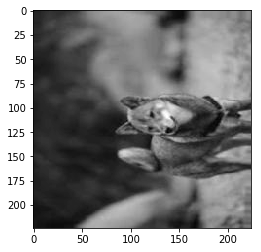

In [17]:
# 잘 됐는지 임의로 하나 출력해보자. 
plt.imshow(resize_dog[2],cmap=plt.cm.gray)
print(labels[2])
plt.show()

In [18]:
# data shuffle

np.random.seed(42)
tmp = [[x,y] for x, y in zip(resize_dog, labels)]
random.shuffle(tmp)
X_sample = [n[0] for n in tmp]
y_sample = [n[1] for n in tmp]

In [19]:
# Train / Test Split
# 80 : 20
train_size = np.ceil(0.8 * len(resize_dog)).astype(int) # 381 / 나머지 95개 test 할당

X_train = X_sample[:train_size]
y_train = y_sample[:train_size]

X_test = X_sample[train_size:]
y_test = y_sample[train_size:]



In [20]:
from keras_preprocessing.image import img_to_array

In [21]:
X_train = img_to_array(X_train)
y_train = np.array(y_train)

X_test = img_to_array(X_test)
y_test = np.array(y_test)

In [22]:
len(X_train), len(y_train), len(X_test), len(y_test)

(1492, 1492, 373, 373)

[0 1]


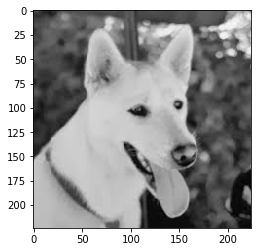

In [23]:
plt.imshow(X_test[1],cmap=plt.cm.gray)
print(y_test[1])
plt.show()

# Network 구축하기 

by Keras

In [24]:
IMG_SIZE = 224
# (None,224,224,1) 형태로 reshape
X_train = X_train.reshape(X_train.shape[0],IMG_SIZE,IMG_SIZE,1)
X_test = X_test.reshape(X_test.shape[0],IMG_SIZE,IMG_SIZE,1)

In [25]:
X_train.shape, X_test.shape

((1492, 224, 224, 1), (373, 224, 224, 1))

In [26]:
from keras import models
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense

Using TensorFlow backend.


In [27]:
IMG_SIZE = 224
def Network(name):
    
    name.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Dropout(0.7))
    name.add(Flatten())
    name.add(Dense(128, activation='relu'))
    name.add(Dropout(0.7))
    name.add(Dense(2, activation = 'softmax'))

In [66]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 10)

# SGD

In [45]:
from keras import optimizers
model_early_sgd = models.Sequential()
Network(model_early_sgd)
model_early_sgd.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=0.01, momentum=0.9), 
              metrics=['accuracy'])

In [33]:
len(X_train), len(y_train)

(1492, 1492)

In [47]:
history_sgd_early = model_early_sgd.fit(X_train,y_train,epochs=30,batch_size=32,verbose=1,validation_split=0.2,callbacks=[early_stopping])

Train on 1193 samples, validate on 299 samples
Epoch 1/30
1193/1193 [==============================] - 96s 81ms/step - loss: 1.7315 - acc: 0.5281 - val_loss: 1.0883 - val_acc: 0.5953
Epoch 2/30
1193/1193 [==============================] - 93s 78ms/step - loss: 1.5637 - acc: 0.5063 - val_loss: 0.7458 - val_acc: 0.5987
Epoch 3/30
1193/1193 [==============================] - 93s 78ms/step - loss: 1.1579 - acc: 0.5432 - val_loss: 0.9524 - val_acc: 0.5552
Epoch 4/30
1193/1193 [==============================] - 94s 79ms/step - loss: 0.8920 - acc: 0.5666 - val_loss: 0.6688 - val_acc: 0.6120
Epoch 5/30
1193/1193 [==============================] - 93s 78ms/step - loss: 0.7383 - acc: 0.5641 - val_loss: 0.6526 - val_acc: 0.6756
Epoch 6/30
1193/1193 [==============================] - 93s 78ms/step - loss: 0.6760 - acc: 0.6094 - val_loss: 0.6395 - val_acc: 0.6589
Epoch 7/30
1193/1193 [==============================] - 101s 84ms/step - loss: 0.6503 - acc: 0.5968 - val_loss: 0.6275 - val_acc: 0.6355


In [48]:
loss, acc = model_early_sgd.evaluate(X_test,y_test,verbose=0)
print("Accuracy : %0.2f" % (acc*100))

Accuracy : 67.56


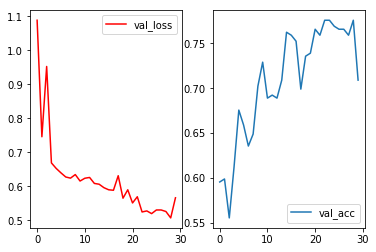

In [49]:
plt.subplot(1,2,1)
plt.plot(history_sgd_early.history['val_loss'],'r-',label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_sgd_early.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

### 모델저장

In [50]:
model_early_sgd.save('model_early_sgd30')

In [53]:
from keras.models import load_model
model_early_sgd100 = load_model("model_early_sgd30")

In [67]:
# 30이후 100번 더 돌기 
# train / val loss acc을 보니 epochs를 늘리면 성능이 더 잘나올 것 같음 
history_sgd_early100 = model_early_sgd100.fit(X_train,y_train,epochs=100,batch_size=32,verbose=1,validation_split=0.2,callbacks=[early_stopping])

Train on 1193 samples, validate on 299 samples
Epoch 1/100
1193/1193 [==============================] - 93s 78ms/step - loss: 0.4252 - acc: 0.8114 - val_loss: 0.6159 - val_acc: 0.6656
Epoch 2/100
1193/1193 [==============================] - 93s 78ms/step - loss: 0.4214 - acc: 0.8181 - val_loss: 0.5928 - val_acc: 0.7023
Epoch 3/100
1193/1193 [==============================] - 94s 78ms/step - loss: 0.4106 - acc: 0.8256 - val_loss: 0.6394 - val_acc: 0.7592
Epoch 4/100
1193/1193 [==============================] - 93s 78ms/step - loss: 0.4038 - acc: 0.8039 - val_loss: 0.5904 - val_acc: 0.7023
Epoch 5/100
1193/1193 [==============================] - 93s 78ms/step - loss: 0.3921 - acc: 0.8231 - val_loss: 0.4305 - val_acc: 0.8060
Epoch 6/100
1193/1193 [==============================] - 95s 79ms/step - loss: 0.3547 - acc: 0.8650 - val_loss: 0.6932 - val_acc: 0.7659
Epoch 7/100
1193/1193 [==============================] - 93s 78ms/step - loss: 0.3699 - acc: 0.8156 - val_loss: 0.7804 - val_acc: 0

In [68]:
loss, acc = model_early_sgd100.evaluate(X_test,y_test,verbose=0)
print("Accuracy : %0.2f" % (acc*100))

Accuracy : 54.69


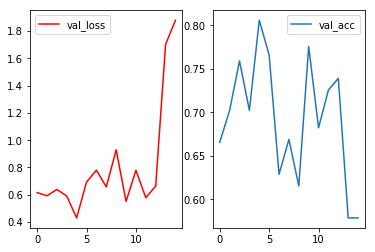

In [69]:
plt.subplot(1,2,1)
plt.plot(history_sgd_early100.history['val_loss'],'r-',label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_sgd_early100.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

# Adadelta

In [70]:
from keras import optimizers
model_early_ada = models.Sequential()
Network(model_early_ada)
model_early_ada.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.adadelta(lr=0.1), 
              metrics=['accuracy'])

In [71]:
history_early = model_early_ada.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1,validation_split=0.2,callbacks=[early_stopping])

Train on 1193 samples, validate on 299 samples
Epoch 1/50
1193/1193 [==============================] - 98s 82ms/step - loss: 2.2916 - acc: 0.5448 - val_loss: 0.8518 - val_acc: 0.6020
Epoch 2/50
1193/1193 [==============================] - 94s 79ms/step - loss: 2.1305 - acc: 0.5457 - val_loss: 0.8539 - val_acc: 0.6288
Epoch 3/50
1193/1193 [==============================] - 106s 89ms/step - loss: 1.9392 - acc: 0.5658 - val_loss: 0.8933 - val_acc: 0.6555
Epoch 4/50
1193/1193 [==============================] - 105s 88ms/step - loss: 2.0466 - acc: 0.5314 - val_loss: 0.8641 - val_acc: 0.6689
Epoch 5/50
1193/1193 [==============================] - 100s 84ms/step - loss: 1.9843 - acc: 0.5658 - val_loss: 0.8638 - val_acc: 0.6856
Epoch 6/50
1193/1193 [==============================] - 104s 87ms/step - loss: 1.8503 - acc: 0.5666 - val_loss: 0.8585 - val_acc: 0.6923
Epoch 7/50
1193/1193 [==============================] - 100s 84ms/step - loss: 1.7513 - acc: 0.5717 - val_loss: 0.8288 - val_acc: 0.6

In [72]:
loss, acc = model_early_ada.evaluate(X_test,y_test,verbose=0)
print("Accuracy : %0.2f" % (acc*100))

Accuracy : 74.26


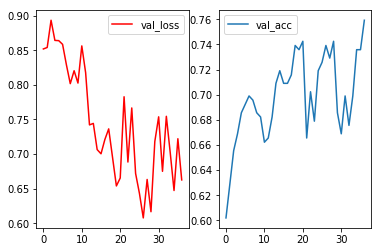

In [73]:
plt.subplot(1,2,1)
plt.plot(history_early.history['val_loss'],'r-',label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_early.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

# 마무리하면서...

처음에는 Training data에 너무 과적합(Overfitting)되는 모습을 보였었다. Training acc는 98%를 넘어서는 반면에 Validation acc, Test acc는 60~70선에서 그치는 양상을 보였었다. 

Overfitting의 원인에 대해서 생각을 해본 결과, 처음에는 Network에 규제가 조금 더 필요하다고 느껴서 Dropout 수치를 계속 올려가면서 성능 개선을 해봤다. 그래서 Dropout을 0.7로 설정했고,  두 번째로 이미지 전처리 과정이 더 필요하다고 느꼈다.

그래서 이미지를 직접 하나하나 보면서 성능에 방해가 될 것 같은 불분명하거나, 사물이 잘 식별되지않는 사진들을 지워줬다. 그리고 이미지를 grayscaling했고, normalization을 추가함으로 써 이미지 전처리에 더 힘을 줬다. 

분석을 하면서 생각이 들었던 것이, 실제로 사람이 두 견종을 보기에도 분별하기가 힘들다고 판단을 했었다. 비슷한 색상에, 비슷한 외모와 체격때문에 많은 요소가 장애물로 작용할 것이라고 생각했다. 그래서 위처럼 진돗개 대신에 비글을 넣어서 분류했더니 90%의 정확도가 나오게 된 것을 보고, 확실히 유사한 외모 때문에 차별적인 요소를 잘 못찾아낸 것 같다. 

이 개인 프로젝트를 통해서 배운 것은, 이미지 전처리과정이 매우 중요하다는 것, 이미지 전처리에 집중하고 또 집중해서 잘 정제된 데이터를 만들어 내는 것이 가장 중요한 과정이라고 생각했다. garbage in - garbage out이라는 말 처럼 데이터의 중요성을 한 번 더 깨달았고, 실생활의 호기심에서 출발해서 이렇게 직접 구현을 해보니 더 배우는 것이 많았다. 생각보다 만만치 않았던 분류였고, 이후에 성능을 높이기 위해 다시 도전을 할 것이다. 

그러기 위해서는 더 준비를 해야하는데, 각 클래스당 10,000장을 수집하고, Color scale로 다시 분류해볼 것이다. 시바견과 진돗개 분류하기 1탄은 여기서 마무리하고 2탄에서는 더 발전된 모습으로 분석할 것이다.

# Image_resize

In [84]:
resize_dog = list()

for dog in X_dog[:n_shiba]:
    img = cv2.imread('./shiba/' + dog,cv2.IMREAD_COLOR)
    resize = cv2.resize(img,(224,224))
    resize = cv2.normalize(resize,resize,0,255,cv2.NORM_MINMAX)    
    resize_dog.append(resize)

In [85]:
len(resize_dog)

915

In [86]:

for i in X_dog[n_shiba:]:
    img = cv2.imread('./진돗개2/'+i,cv2.IMREAD_COLOR)
    resize = cv2.resize(img,(224,224))
    resize = cv2.normalize(resize,resize,0,255,cv2.NORM_MINMAX)
    resize_dog.append(resize)


In [87]:
len(resize_dog)

1865

[1, 0]


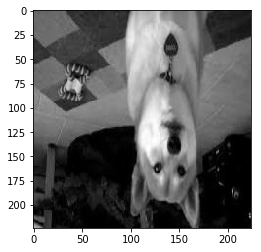

In [94]:
# 잘 됐는지 임의로 하나 출력해보자. 
plt.imshow(resize_dog[120])
print(labels[100])
plt.show()

In [95]:
# data shuffle

np.random.seed(42)
tmp = [[x,y] for x, y in zip(resize_dog, labels)]
random.shuffle(tmp)
X_sample = [n[0] for n in tmp]
y_sample = [n[1] for n in tmp]

In [96]:
# Train / Test Split
# 80 : 20
train_size = np.ceil(0.8 * len(resize_dog)).astype(int) # 381 / 나머지 95개 test 할당

X_train = X_sample[:train_size]
y_train = y_sample[:train_size]

X_test = X_sample[train_size:]
y_test = y_sample[train_size:]



In [97]:
from keras_preprocessing.image import img_to_array

In [102]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [103]:
len(X_train), len(y_train), len(X_test), len(y_test)

(1492, 1492, 373, 373)

[0 1]


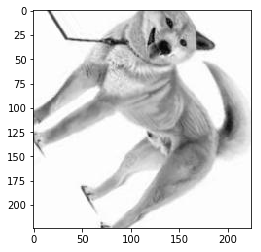

In [104]:
plt.imshow(X_test[1],cmap=plt.cm.gray)
print(y_test[1])
plt.show()

# Network 구축하기 

by Keras

In [105]:
IMG_SIZE = 224
# (None,224,224,1) 형태로 reshape
X_train = X_train.reshape(X_train.shape[0],IMG_SIZE,IMG_SIZE,3)
X_test = X_test.reshape(X_test.shape[0],IMG_SIZE,IMG_SIZE,3)

In [106]:
X_train.shape, X_test.shape

((1492, 224, 224, 3), (373, 224, 224, 3))

In [107]:
from keras import models
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense

In [108]:
IMG_SIZE = 224
def Network(name):
    
    name.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    name.add(MaxPooling2D(pool_size=(2,2)))
    name.add(BatchNormalization())
    name.add(Dropout(0.7))
    name.add(Flatten())
    name.add(Dense(128, activation='relu'))
    name.add(Dropout(0.7))
    name.add(Dense(2, activation = 'softmax'))

In [109]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 10)

# SGD

In [112]:
from keras import optimizers
model_early_sgd = models.Sequential()
Network(model_early_sgd)
model_early_sgd.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=0.01, momentum=0.9), 
              metrics=['accuracy'])

In [113]:
len(X_train), len(y_train)

(1492, 1492)

In [114]:
history_sgd_early = model_early_sgd.fit(X_train,y_train,epochs=30,batch_size=32,verbose=1,validation_split=0.2,callbacks=[early_stopping])

Train on 1193 samples, validate on 299 samples
Epoch 1/30
1193/1193 [==============================] - 105s 88ms/step - loss: 1.8085 - acc: 0.5130 - val_loss: 1.2436 - val_acc: 0.6254
Epoch 2/30
1193/1193 [==============================] - 102s 85ms/step - loss: 1.6172 - acc: 0.5381 - val_loss: 0.8306 - val_acc: 0.5619
Epoch 3/30
1193/1193 [==============================] - 101s 84ms/step - loss: 1.2942 - acc: 0.5566 - val_loss: 6.5774 - val_acc: 0.4849
Epoch 4/30
1193/1193 [==============================] - 106s 89ms/step - loss: 1.2127 - acc: 0.5457 - val_loss: 0.8532 - val_acc: 0.6254
Epoch 5/30
1193/1193 [==============================] - 107s 89ms/step - loss: 0.7757 - acc: 0.5499 - val_loss: 0.6557 - val_acc: 0.6154
Epoch 6/30
1193/1193 [==============================] - 104s 87ms/step - loss: 0.6945 - acc: 0.5784 - val_loss: 0.6734 - val_acc: 0.6054
Epoch 7/30
1193/1193 [==============================] - 110s 93ms/step - loss: 0.6748 - acc: 0.6060 - val_loss: 0.6381 - val_acc: 0

In [115]:
loss, acc = model_early_sgd.evaluate(X_test,y_test,verbose=0)
print("Accuracy : %0.2f" % (acc*100))

Accuracy : 73.46


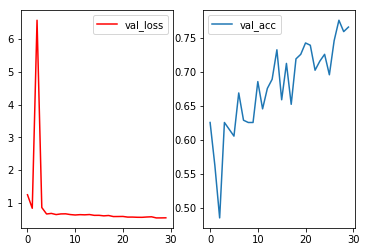

In [116]:
plt.subplot(1,2,1)
plt.plot(history_sgd_early.history['val_loss'],'r-',label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_sgd_early.history['val_acc'],label='val_acc')
plt.legend()
plt.show()